In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


In [2]:
df = pd.read_csv("../data/keggs-subjects-rf-scores.csv")

df.head()

,kegg,over.abundant.health.conf,LS001,LS002,LS003,LS004,LS005,LS006,LS007,CD.SRS301865,...,HE.SRS016335,HE.SRS016495,HE.SRS017103,HE.SRS017433,HE.SRS018427,HE.SRS018656,HE.SRS020328,HE.SRS020869,HE.SRS022713,HE.SRS016585.suspect
0,K00001(alcohol_dehydrogenase),0.366,0.005732,0.006140,0.006243,0.005962,0.008011,0.004744,0.005444,0.005043,...,0.002705,0.005025,0.003359,0.004281,0.003052,0.003625,0.002673,0.003999,0.003734,8.220359e-03
1,K00002(alcohol_dehydrogenase_(NADP+)),0.312,0.000382,0.000409,0.000610,0.000533,0.000313,0.000412,0.000390,0.001005,...,0.000461,0.000255,0.000071,0.000014,0.000248,0.000649,0.000151,0.000157,0.000000,4.812945e-07
2,K00003(homoserine_dehydrogenase),0.310,0.000855,0.001034,0.001125,0.001074,0.001224,0.000721,0.000786,0.001025,...,0.000195,0.001063,0.000249,0.000131,0.000351,0.000676,0.000430,0.000318,0.000050,1.209999e-06
3,"K00004((R,R)-butanediol_dehydrogenase_/_diacet...",0.192,0.000091,0.000106,0.000149,0.000116,0.000064,0.000084,0.000080,0.000016,...,0.000006,0.000025,0.000008,0.000008,0.000014,0.000039,0.000068,0.000010,0.000006,4.127393e-04
4,K00005(glycerol_dehydrogenase),0.004,0.000167,0.000236,0.000223,0.000203,0.000218,0.000144,0.000143,0.000166,...,0.000012,0.000427,0.000030,0.000004,0.000034,0.000036,0.000055,0.000065,0.000000,2.158647e-04


In [3]:
def pairwise_diffs(np_arr):
    np_diffs = np.empty((len(np_arr)*(len(np_arr)-1)/2, np_arr.shape[1]))
    start_ind = 0
    for i in range(len(np_arr)-1):
        sample = np_arr[i,:]
        diffs = np.sqrt((np_arr[i+1:,:] - sample)**2)
        end_ind = start_ind+len(diffs)
        np_diffs[start_ind:end_ind,:] = diffs
        start_ind = end_ind

    return np_diffs

In [4]:
X = df.iloc[:,2:].values.T

y = np.zeros(X.shape[0]) # 0 is healthy

y[np.where(df.iloc[:, 2:].columns.str.contains("LS"))[0]] = 1 # 1 is LS
y[np.where(df.iloc[:, 2:].columns.str.contains("CD"))[0]] = 2 # 1 is LS
y[np.where(df.iloc[:, 2:].columns.str.contains("UC"))[0]] = 3 # 1 is LS

In [5]:
X.shape

(63, 10012)

In [6]:
laplace_scale = 1e-9
X_diffs = pairwise_diffs(np.log10(X + laplace_scale))

In [7]:
y_diffs = pairwise_diffs(y[:, np.newaxis]).squeeze()
y_diffs.shape

y_diffs[y_diffs > 0] = 1

In [8]:
from sklearn.linear_model import LogisticRegressionCV

In [25]:
LR = LogisticRegressionCV(Cs = np.logspace(-3, 3, 50), penalty="l2", solver="liblinear", n_jobs=-2)

In [26]:
LR.fit(X_diffs, 1- y_diffs)

LogisticRegressionCV(Cs=array([  1.00000e-03,   1.32571e-03,   1.75751e-03,   2.32995e-03,
         3.08884e-03,   4.09492e-03,   5.42868e-03,   7.19686e-03,
         9.54095e-03,   1.26486e-02,   1.67683e-02,   2.22300e-02,
         2.94705e-02,   3.90694e-02,   5.17947e-02,   6.86649e-02,
         9.10298e-02,   1.206...     2.44205e+02,   3.23746e+02,   4.29193e+02,   5.68987e+02,
         7.54312e+02,   1.00000e+03]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-2, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

In [28]:
LR.coef_.shape

(1, 10012)

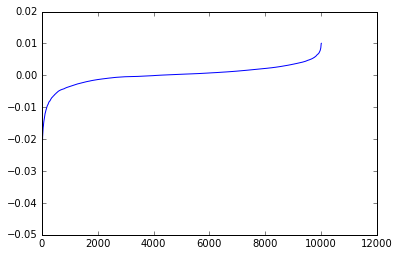

In [29]:
plt.plot(np.sort(LR.coef_.squeeze()))

In [30]:
np.sort(LR.coef_)

array([[-0.04146155, -0.03158382, -0.02975329, ...,  0.01000636,
         0.01006017,  0.01006248]])

In [33]:
LR.coef_[LR.coef_ < -.01].shape

(173,)

In [38]:
df_res = pd.DataFrame({"Logistic Regression KEGGs": df["kegg"][LR.coef_.squeeze() < -.01]})

df_res.to_csv("../results/KEGGs-logistic-regression-pairwise-weights.csv", index = False)

In [43]:
LR.coef_[LR.coef_ > .007]

(85,)

In [44]:
df_res = pd.DataFrame({"Logistic Regression KEGGs": df["kegg"][LR.coef_.squeeze() > .007]})

df_res.to_csv("../results/KEGGs-logistic-regression-pairwise-weights-different-groups.csv", index = False)